## Base Configurations

In [112]:
import pymongo
import pandas as pd
from pymongo import MongoClient
from random import random
import json

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from collections import Counter
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

In [113]:
# Verinin typeları düzenlenecek
# Outlier gözlemi yapılacak -- Açıklama yazılacak.
# Individual EDA yapılacak
# Yeni featurelar ile household birleştirilip model üretilecek 2-3 tane ağaç algoritması
# Model scoreları incelenecek
# Bu modeli pickle olarak mongodb'ye aktarılacak
# Sunum hazırlanacak

In [155]:
client = MongoClient("mongodb://localhost:27017/")

In [156]:
db = client.COMP

In [157]:
collection_household = db['HOUSEHOLD']
collection_individual = db['INDIVIDUAL']

In [158]:
def get_DF(collection):
    # Create a cursor to fetch data
    cursor = collection.find({})  # You can add query conditions inside find()

    # Convert cursor data to a list of dictionaries
    data_list = list(cursor)

    # Create a DataFrame
    df = pd.DataFrame(data_list)
    
    return df

In [159]:
df_individual = get_DF(collection_individual)
df_household = get_DF(collection_household)

In [160]:
df_individual.drop("_id",axis =1 ,inplace = True)
df_household.drop("_id",axis =1 ,inplace = True)

In [161]:
# Close the MongoDB connection
client.close()

## Ingesting the Data

In [162]:
# Data Info
df_household.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   hid           8000 non-null   object
 1   geo1          8000 non-null   object
 2   geo2          8000 non-null   object
 3   ea            8000 non-null   object
 4   urbrur        8000 non-null   object
 5   hhsize        8000 non-null   object
 6   statocc       8000 non-null   object
 7   rooms         8000 non-null   object
 8   bedrooms      8000 non-null   object
 9   floor         8000 non-null   object
 10  walls         8000 non-null   object
 11  roof          8000 non-null   object
 12  water         8000 non-null   object
 13  piped_water   8000 non-null   object
 14  toilet        8000 non-null   object
 15  flush_toilet  8000 non-null   object
 16  electricity   8000 non-null   object
 17  cook_fuel     8000 non-null   object
 18  phone         8000 non-null   object
 19  cell  

In [163]:
df_household["quint_urb"].value_counts()

     3550
5    1279
4     987
3     873
2     748
1     563
Name: quint_urb, dtype: int64

In [164]:
df_household[df_household["quint_urb"] == ""]

hid geo1 geo2     ea urbrur hhsize statocc rooms bedrooms floor  \
1001  b4f4894e378    8   83  83092      1      5       1     2        1     1   
1002  b63e30c5431    8   83  83092      1      5       1     5        2     1   
1003  b779e26decf    8   83  83092      1      3       1     3        2     2   
1005  ba99ce93d5f    8   83  83092      1      4       1     3        2     2   
1006  bac52567744    8   83  83099      1      7       1     1        0     2   
...           ...  ...  ...    ...    ...    ...     ...   ...      ...   ...   
7995  e57647fc128    5   51  51017      1      4       1     3        2     2   
7996  e7f326fc7ec    5   51  51018      1      4       1     2        1     1   
7997  ecb4aeea3b0    5   51  51017      1      4       1     2        2     2   
7998  ed7b98d01a7    5   51  51017      1      4       1     3        2     2   
7999  eebcf6d8348    5   51  51017      1      4       1     4        3     2   

      ... exp_12 tot_exp tot_food           share_food              pc_exp  \
1001  ...    749    7737     2305   0.2980000078678131  1547.4000244140625   
1002  ...   1306   18650     4497   0.2409999966621399              3730.0   
1003  ...    243   13076     7463   0.5709999799728394    4358.66650390625   
1005  ...    693    9984     3001   0.3009999990463257              2496.0   
1006  ...    983   13387     5011  0.37400001287460327  1912.4285888671875   
...   ...    ...     ...      ...                  ...                 ...   
7995  ...    603   10675     4704   0.4410000145435333             2668.75   
7996  ...     85    8991     6101   0.6790000200271606             2247.75   
7997  ...    690    9792     3356  0.34299999475479126              2448.0   
7998  ...    364   15367     7902   0.5139999985694885             3841.75   
7999  ...   1607   17088     4848   0.2840000092983246              4272.0   

     quint_nat quint_urb quint_rur            hhweight           popweight  
1001         2                   2  506.27557131998987   2531.377856599949  
1002         4                   5  506.27557131998987   2531.377856599949  
1003         5                   5  506.27557131998987  1518.8267139599695  
1005         3                   4  506.27557131998987  2025.1022852799595  
1006         2                   3   409.8850266024829  2869.1951862173805  
...        ...       ...       ...                 ...                 ...  
7995         3                   4  218.66888744307087   874.6755497722835  
7996         3                   4   355.3369420949902  1421.3477683799608  
7997         3                   4  218.66888744307087   874.6755497722835  
7998         4                   5  218.66888744307087   874.6755497722835  
7999         5                   5  218.66888744307087   874.6755497722835  

[3550 rows x 49 columns]

## Exploratory Data Analysis

You can analyze following steps; 

* Identify Categorical and Numerical Columns
* Calculate Basic Statistics(mean, standard deviation, minimum, and maximum values)
* Examine Missing Data
* Examine Categoric and Numeric Variables
* Data Visualization
* Correlation Analysis
* Identifiying Outliers



## Initial Analysis for Household Data

Since this is the dataset which we will use as our core, we thought it would be better to start analysing this one first. As we shown in our previous step, this is a large dataset in terms of the features it has. We will be trying to find the best approaches to handle each of these columns. After reading the documentation carefully, we initilize our work.

### Duplicated Rows

In [165]:
df_household[df_household.duplicated()]

Empty DataFrame
Columns: [hid, geo1, geo2, ea, urbrur, hhsize, statocc, rooms, bedrooms, floor, walls, roof, water, piped_water, toilet, flush_toilet, electricity, cook_fuel, phone, cell, car, bicycle, motorcycle, refrigerator, tv, radio, bank, deaths_12m, exp_01, exp_02, exp_03, exp_04, exp_05, exp_06, exp_07, exp_08, exp_09, exp_10, exp_11, exp_12, tot_exp, tot_food, share_food, pc_exp, quint_nat, quint_urb, quint_rur, hhweight, popweight]
Index: []

[0 rows x 49 columns]

Since we don't have any problems with duplicates, we move on.

### Numerical Features

As we have been learning a lot in our classes, categorical and numerical columns are typically handled in different manners. Our dataset includes both of these types. We go on and start by identifying them. For this, we used the documetation provided to us. 

One thing to mention here, dataset features are ordered in a really nice way. Upon checking the documentation, we realised that 
after "exp_01" feature (including itself), every feature happens to be numeric till quint_nat, quint_urb and quint_rur(44th ,45th and 46th features, respectively). We seperated the dataframe accordingly.

*** We didn't use 47th and 48th features because they were not included in the data dictionary. 

In [166]:
df_household_num = df_household.iloc[:, [0] + list(range(28,45))].copy()

In [167]:
def convert_to_numeric_except_first(df):
    df_numeric = df.copy()
    
    # Convert all columns to numeric, excluding the first column
    for column_name in df.columns[1:]:
        df_numeric[column_name] = pd.to_numeric(df[column_name], errors='coerce')  # 'coerce' converts non-numeric values to NaN

    return df_numeric

df_household_num = convert_to_numeric_except_first(df_household_num)

Our numeric columns look just fine. Let's check their data types before moving on.

In [168]:
df_household_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hid         8000 non-null   object 
 1   exp_01      8000 non-null   int64  
 2   exp_02      8000 non-null   int64  
 3   exp_03      8000 non-null   int64  
 4   exp_04      8000 non-null   int64  
 5   exp_05      8000 non-null   int64  
 6   exp_06      8000 non-null   int64  
 7   exp_07      8000 non-null   int64  
 8   exp_08      8000 non-null   int64  
 9   exp_09      8000 non-null   int64  
 10  exp_10      8000 non-null   int64  
 11  exp_11      8000 non-null   int64  
 12  exp_12      8000 non-null   int64  
 13  tot_exp     8000 non-null   int64  
 14  tot_food    8000 non-null   int64  
 15  share_food  8000 non-null   float64
 16  pc_exp      8000 non-null   float64
 17  quint_nat   8000 non-null   int64  
dtypes: float64(2), int64(15), object(1)
memory usage: 1.1+ MB


All of them look okay. We will do the same for the categorical ones now.

In [ ]:
"""
def remove_outliers_iqr_all_columns(df):
    df_no_outliers = df.copy()

    for column_name in df.columns[1:]:
        if pd.api.types.is_numeric_dtype(df[column_name]):
            # Calculate quartiles and IQR
            Q1 = df[column_name].quantile(0.1)
            Q3 = df[column_name].quantile(0.9)
            IQR = Q3 - Q1
            
            # Define the lower and upper bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Remove outliers
            df_no_outliers = df_no_outliers[(df_no_outliers[column_name] >= lower_bound) & (df_no_outliers[column_name] <= upper_bound)]

    return df_no_outliers

df_household_num = remove_outliers_iqr_all_columns(df_household_num)
"""

### Categorical Features

In [197]:
df_household_cat=df_household.iloc[:, list(range(27)) + [44,45, 46]].copy()

In [198]:
df_household_cat

hid geo1 geo2     ea urbrur hhsize statocc rooms bedrooms floor  \
0     00a191396a2    1   11  11066      2      1       1     1        1     2   
1     0111c7fa67c    1   11  11066      2      1       2     1        0     2   
2     01410d9c60d    1   11  11087      2      2       1     4        1     2   
3     015ff82b55c    1   11  11094      2      2       1     1        1     2   
4     01c39d3df0d    1   11  11094      2      1       2     3        2     6   
...           ...  ...  ...    ...    ...    ...     ...   ...      ...   ...   
7995  e57647fc128    5   51  51017      1      4       1     3        2     2   
7996  e7f326fc7ec    5   51  51018      1      4       1     2        1     1   
7997  ecb4aeea3b0    5   51  51017      1      4       1     2        2     2   
7998  ed7b98d01a7    5   51  51017      1      4       1     3        2     2   
7999  eebcf6d8348    5   51  51017      1      4       1     4        3     2   

      ... car bicycle motorcycle refrigerator tv radio bank quint_nat  \
0     ...   0       0          0            1  1     0    0         5   
1     ...   0       0          0            0  0     0    1         5   
2     ...   0       0          0            1  1     1    1         5   
3     ...   0       0          0            1  1     0    1         5   
4     ...   1       0          0            1  1     0    1         5   
...   ...  ..     ...        ...          ... ..   ...  ...       ...   
7995  ...   0       0          0            1  1     1    0         3   
7996  ...   0       0          0            0  0     1    0         3   
7997  ...   0       0          0            1  1     0    0         3   
7998  ...   0       0          0            1  1     1    1         4   
7999  ...   0       0          0            1  1     1    1         5   

     quint_urb quint_rur  
0            4            
1            4            
2            4            
3            5            
4            5            
...        ...       ...  
7995                   4  
7996                   4  
7997                   4  
7998                   5  
7999                   5  

[8000 rows x 30 columns]

We will check their datatypes just like we did for the numeric ones.

In [199]:
df_household_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   hid           8000 non-null   object
 1   geo1          8000 non-null   object
 2   geo2          8000 non-null   object
 3   ea            8000 non-null   object
 4   urbrur        8000 non-null   object
 5   hhsize        8000 non-null   object
 6   statocc       8000 non-null   object
 7   rooms         8000 non-null   object
 8   bedrooms      8000 non-null   object
 9   floor         8000 non-null   object
 10  walls         8000 non-null   object
 11  roof          8000 non-null   object
 12  water         8000 non-null   object
 13  piped_water   8000 non-null   object
 14  toilet        8000 non-null   object
 15  flush_toilet  8000 non-null   object
 16  electricity   8000 non-null   object
 17  cook_fuel     8000 non-null   object
 18  phone         8000 non-null   object
 19  cell  

We will convert all these to categorical columns.

In [200]:
df_household_cat = df_household_cat.astype('category')


In [201]:
df_household_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   hid           8000 non-null   category
 1   geo1          8000 non-null   category
 2   geo2          8000 non-null   category
 3   ea            8000 non-null   category
 4   urbrur        8000 non-null   category
 5   hhsize        8000 non-null   category
 6   statocc       8000 non-null   category
 7   rooms         8000 non-null   category
 8   bedrooms      8000 non-null   category
 9   floor         8000 non-null   category
 10  walls         8000 non-null   category
 11  roof          8000 non-null   category
 12  water         8000 non-null   category
 13  piped_water   8000 non-null   category
 14  toilet        8000 non-null   category
 15  flush_toilet  8000 non-null   category
 16  electricity   8000 non-null   category
 17  cook_fuel     8000 non-null   category
 18  phone   

### Basic Statistics

For this part,  we will be checking the statistics info of our numeric variables to gain some insight. This will also be important on our outlier detection part. 

In [40]:
df_household_num.describe()

exp_01       exp_02       exp_03        exp_04       exp_05  \
count   8000.000000  8000.000000  8000.000000   8000.000000  8000.000000   
mean    3774.062125    93.329250   663.703000   3083.725125   549.597500   
std     1742.040421    87.846963   446.776155   2328.139360   532.626896   
min      409.000000     0.000000    24.000000    121.000000    27.000000   
25%     2611.000000    37.000000   335.000000   1228.500000   230.000000   
50%     3508.500000    64.000000   587.000000   2651.500000   362.000000   
75%     4664.000000   119.000000   868.000000   4184.000000   653.000000   
max    18397.000000  1084.000000  3755.000000  24552.000000  5139.000000   

            exp_06        exp_07       exp_08       exp_09       exp_10  \
count  8000.000000   8000.000000  8000.000000  8000.000000  8000.000000   
mean    288.231000   1167.769625   497.435875   330.275875   568.147375   
std     238.622042   1441.885225   571.408457   363.674961   721.643406   
min      13.000000     14.000000     0.000000     2.000000     0.000000   
25%     117.000000    279.000000    85.000000    96.000000    92.000000   
50%     216.000000    571.000000   312.000000   212.000000   313.000000   
75%     384.000000   1400.250000   663.000000   425.000000   767.000000   
max    1968.000000  14035.000000  4545.000000  3984.000000  7410.000000   

            exp_11       exp_12       tot_exp      tot_food   share_food  \
count  8000.000000  8000.000000   8000.000000   8000.000000  8000.000000   
mean    354.233000   706.642250  12077.152000   3774.062125     0.364376   
std     309.593327   545.641374   7381.022408   1742.040421     0.166257   
min       7.000000    10.000000   1421.000000    409.000000     0.079000   
25%     137.000000   273.000000   7044.000000   2611.000000     0.240000   
50%     267.000000   636.000000  10308.000000   3508.500000     0.319000   
75%     471.000000   980.000000  14848.000000   4664.000000     0.480000   
max    3274.000000  6765.000000  76247.000000  18397.000000     0.828000   

             pc_exp  
count   8000.000000  
mean    3665.114230  
std     2863.957576  
min      528.625000  
25%     1869.416656  
50%     2799.812500  
75%     4519.625000  
max    34938.500000

### Missing Data

We will be checking the missing data status for both our frames.

Let's start with the numeric one.

In [41]:
df_household_num.isna().sum() / len(df_household_num) * 100

exp_01        0.0
exp_02        0.0
exp_03        0.0
exp_04        0.0
exp_05        0.0
exp_06        0.0
exp_07        0.0
exp_08        0.0
exp_09        0.0
exp_10        0.0
exp_11        0.0
exp_12        0.0
tot_exp       0.0
tot_food      0.0
share_food    0.0
pc_exp        0.0
dtype: float64

This is really good to see. There are no missing data points in our numerical frame.

In [42]:
df_household_cat.isna().sum() / len(df_household_num) * 100

hid              0.000
geo1             0.000
geo2             0.000
ea               0.000
urbrur           0.000
hhsize           0.000
statocc          0.000
rooms            0.000
bedrooms         0.000
floor            0.000
walls            0.000
roof             0.000
water            0.000
piped_water      0.000
toilet           0.000
flush_toilet     0.000
electricity      0.000
cook_fuel        0.000
phone            0.000
cell             0.000
car              0.000
bicycle          0.000
motorcycle       0.000
refrigerator     0.000
tv               0.000
radio            0.000
bank             0.000
quint_nat        0.000
quint_urb       44.375
quint_rur       55.625
dtype: float64

Most of our categorical features don't have any missing data points.However, "quint_urb" and "quint_rur" columns have almost half of their values missing. We will decide what to do with them after our correlation analysis. 

### Numerical Data Correlation Analysis

Before checking the correlation as a number, we wanted to see our numerical features as pairplots. 

C:\Users\erent\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


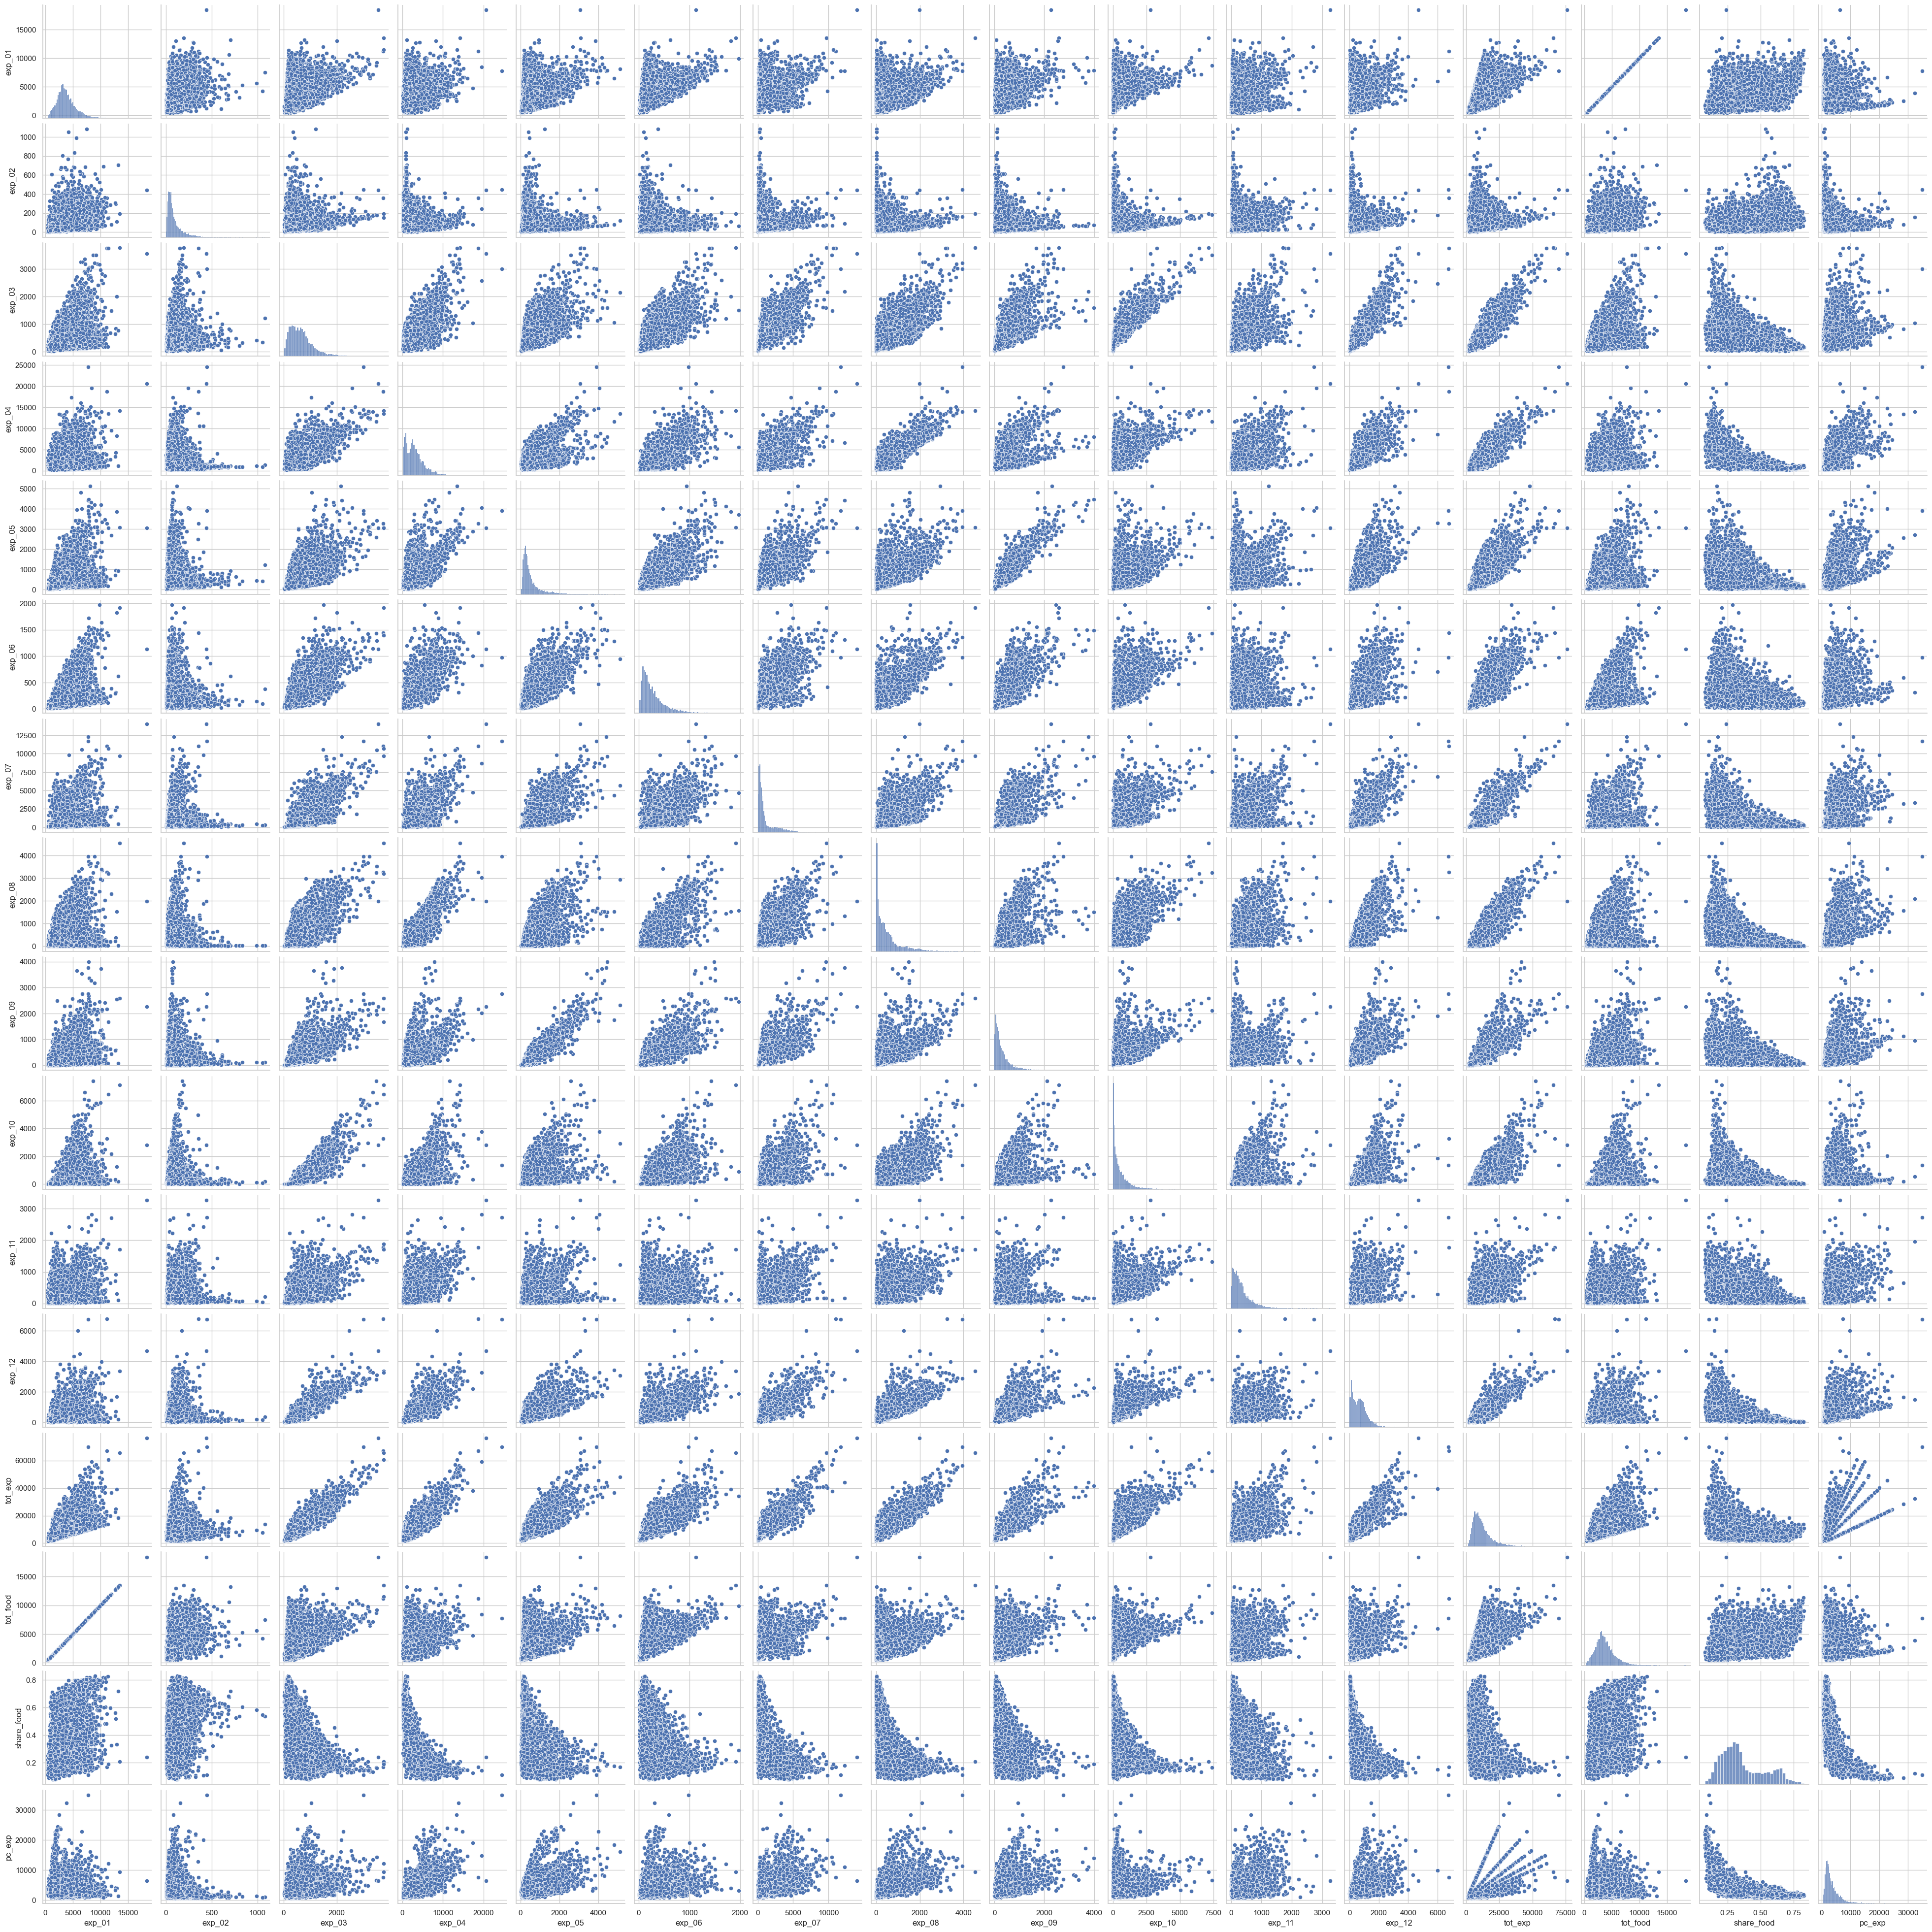

In [43]:
sns.pairplot(df_household_num)

There are some columns which are so correlated with each other. That is not known to be a good indicator for our model. For instance, exp-01 and tot-food columns look like they have a perfect linear relation. There are also others which seem like in a relation. We will also check with our correlation matrix to understand better.

<Axes: >

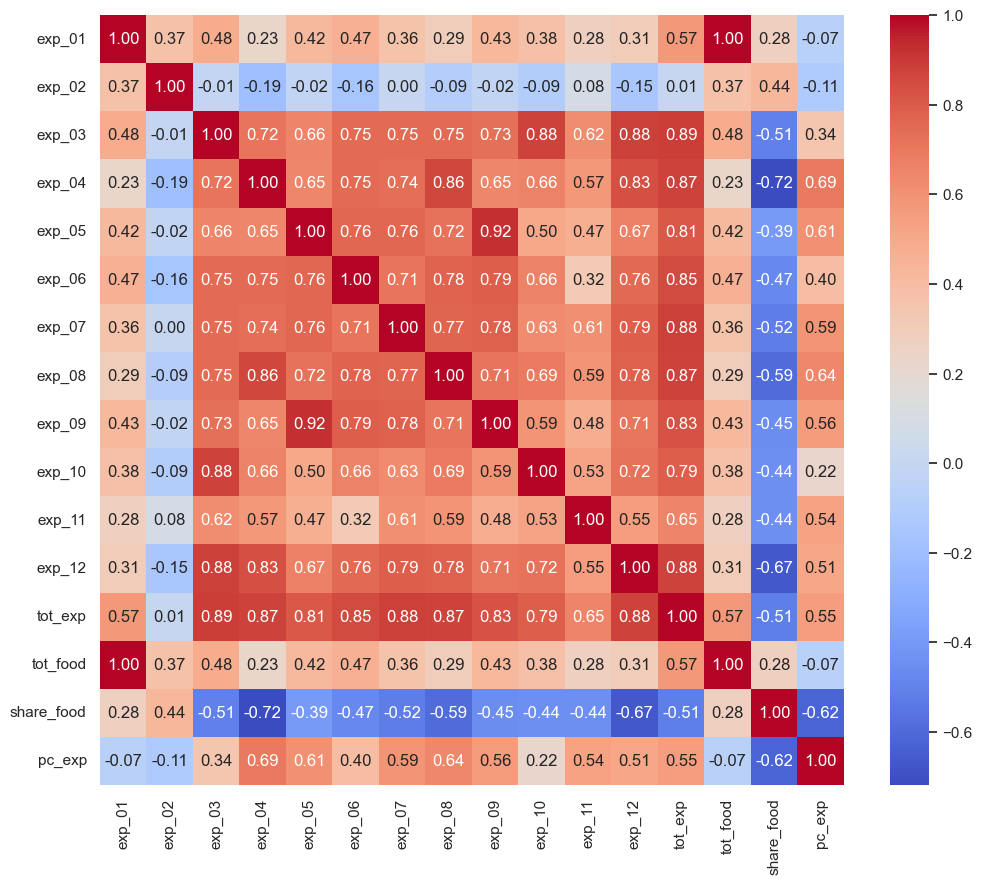

In [46]:
correlation_matrix = df_household_num.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

Just like we suspected, exp_01 and tot_food columns have a correlation which is set at "1". This is an indicator of perfect multicollinearity. We will drop one of them.  

Moreover, we realised that the tot_expenditure feature is highly correlated with other expenditures. We can basically say that the variability in that column can be explained by other expenditures. We will also drop that column. 

### Categorical Data Statistical Analysis

As we have also shown, we have lots of categorical features. We will select some of them and try to draw conclusions about our dataset. This part is both about curiosity and statistics.

For the categorical features, we wanted to perform some chi^2 contingency tests to dig deeper in our analysis. We will read the documentation carefully for this part.

#### Can we statistically back that there is a relation with having bank account and a landline phone?

In [49]:
ct = pd.crosstab(df_household_cat["bank"],df_household_cat["phone"])
print(ct)
chi2_contingency(ct,lambda_="log-likelihood")

phone     0     1
bank             
0      3206   197
1      2994  1603


Chi2ContingencyResult(statistic=1078.2769238941828, pvalue=1.739057985774843e-236, dof=1, expected_freq=array([[2637.325,  765.675],
       [3562.675, 1034.325]]))

This basically means that we can reject the null hyphothesis which there is no relation between them with a really high confidence level. P-value is extremely small in our case. 

#### Can we statistically back that there is a relation with having a cell phone and a car?

In [50]:
ct = pd.crosstab(df_household_cat["cell"],df_household_cat["car"])
print(ct)
chi2_contingency(ct,lambda_="log-likelihood")

car      0     1
cell            
0     2652   299
1     3387  1662


Chi2ContingencyResult(statistic=575.4475307706876, pvalue=3.6672635376598956e-127, dof=1, expected_freq=array([[2227.636125,  723.363875],
       [3811.363875, 1237.636125]]))

#### Can we statistically back that there is a relation with having electricty and the type of water supply?

In [59]:
ct = pd.crosstab(df_household_cat["piped_water"],df_household_cat["electricity"])
print(ct)
chi2_contingency(ct,lambda_="log-likelihood")

electricity     0     1
piped_water            
0            1104  2156
1             146  4306
2              30   124
3              72    62


Chi2ContingencyResult(statistic=1473.0990938742616, pvalue=0.0, dof=3, expected_freq=array([[ 550.94 , 2709.06 ],
       [ 752.388, 3699.612],
       [  26.026,  127.974],
       [  22.646,  111.354]]))

## Target Analysis

* Rural (1): There are 3550 instances classified as rural.
* Urban (2): There are 4450 instances classified as urban.



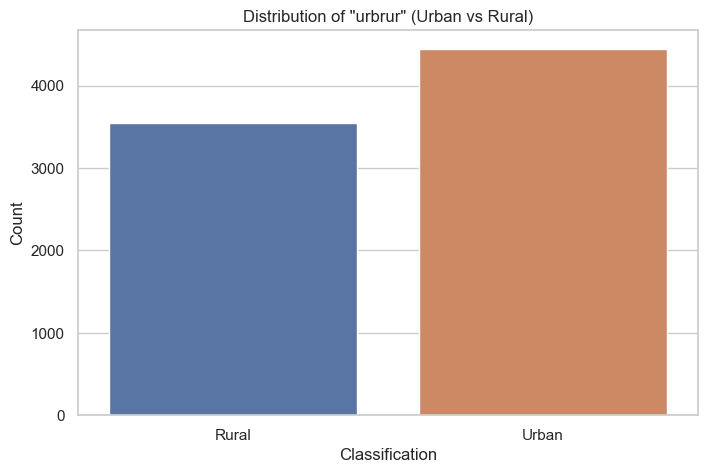

urbrur
2    4450
1    3550
Name: count, dtype: int64

In [60]:

urbrur_counts = df_household_cat['urbrur'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=urbrur_counts.index, y=urbrur_counts.values)
plt.title('Distribution of "urbrur" (Urban vs Rural)')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Rural', 'Urban'])  
plt.show()

urbrur_counts

By looking at the classes, we see that we have a nice distribution of our two main columns. For classification tasks, it is important for our target classes to have a close distribution of their categories.

## Finding Relations between Our Target and Features

### Home Ownership and our Target (Urban or Rural)

Let's find out how is the "home ownership" compare depending on Rural and Urban areas.

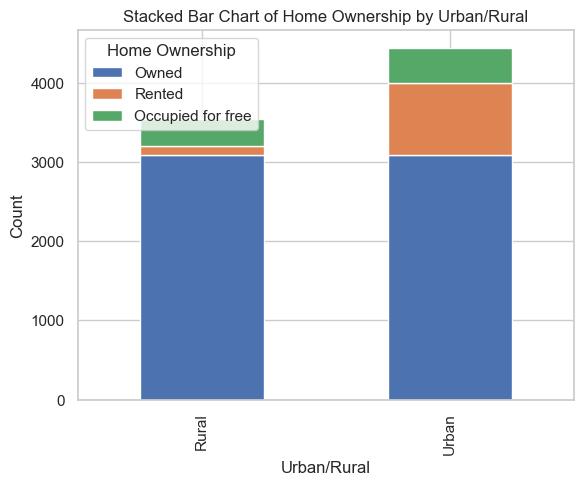

In [96]:
cross_tab_result = pd.crosstab(df_household_cat["statocc"].replace({1:"Owned",2:"Rented",3:"Occupied for free"}), df_household_cat["urbrur"].replace({1:"Rural",2:"Urban"})).T
cross_tab_result[["Owned", "Rented","Occupied for free"]]

gra = cross_tab_result.plot(kind='bar', stacked=True)
gra.set_xlabel("Urban/Rural")
gra.set_ylabel("Count")
gra.set_title("Stacked Bar Chart of Home Ownership by Urban/Rural")


gra.legend(title="Home Ownership")


plt.show()

Let's also see it in numbers.

In [85]:
pd.crosstab(df_household_cat["statocc"].replace({1:"Owned",2:"Rented",3:"Occupied for free"}), df_household_cat["urbrur"].replace({1:"Rural",2:"Urban"}))

urbrur             Rural  Urban
statocc                        
Owned               3095   3092
Rented               111    910
Occupied for free    344    448

Finally, let's look at the numbers from a statistical point of view once again.

In [97]:
ct = pd.crosstab(df_household_cat["statocc"].replace({1:"Owned",2:"Rented",3:"Occupied for free"}),df_household_cat["urbrur"].replace({1:"Rural",2:"Urban"}))
print(ct)
chi2_contingency(ct,lambda_="log-likelihood")

urbrur             Rural  Urban
statocc                        
Owned               3095   3092
Rented               111    910
Occupied for free    344    448


Chi2ContingencyResult(statistic=625.5500715377394, pvalue=1.457229278601687e-136, dof=2, expected_freq=array([[2745.48125, 3441.51875],
       [ 453.06875,  567.93125],
       [ 351.45   ,  440.55   ]]))

### Floor Materials in Urban/Rural Houses

Another feature which we were really curious about was the "floor material". We thought houses in rural areas and urban areas differ quite a lot in terms of materials used in their floor.

We wanted to see this in different piecharts. Let's check the rural one first. 

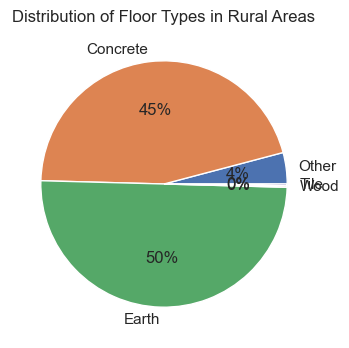

In [110]:
rural_floor_counts = Counter(df_household_cat[df_household_cat["urbrur"] == 1]["floor"].replace({1: "Earth", 2: "Concrete", 3: "Tile", 4: "Stone", 5: "Wood", 6: "Other"}))


plt.figure(figsize=(6, 4))
plt.pie(rural_floor_counts.values(), labels=rural_floor_counts.keys(), autopct='%.0f%%')


plt.title("Distribution of Floor Types in Rural Areas")


plt.show()

As we also also anticipated, "Earth" is a common option for rural areas.

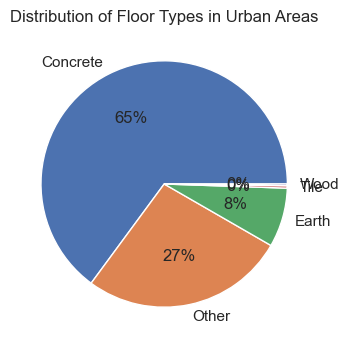

In [109]:
urban_floor_counts = Counter(df_household_cat[df_household_cat["urbrur"] == 2]["floor"].replace({1: "Earth", 2: "Concrete", 3: "Tile", 4: "Stone", 5: "Wood", 6: "Other"}))


plt.figure(figsize=(6, 4))
plt.pie(urban_floor_counts.values(), labels=urban_floor_counts.keys(), autopct='%.0f%%')


plt.title("Distribution of Floor Types in Urban Areas")


plt.show()

"Concrete" is 8 time more popular than the "Earth" material in Urban areas.

## Feature Extraction

We are expecting you to prepare new variables from the Individual dataset. You can combine these 2 datasets via 'hid' columns. First of all, the Individual dataset contains the characteristics of individuals within each family. After deduplicating(or aggregation) these features based on the 'hid' column, that is, after creating new variables, we expect you to add them to the Household dataset as new feature columns. Examples are given to you below. You may increase the number of features extracted.

Note: Since you will be generating new variables from Individual dataset, you can perform similar data exploratory analyzes within this dataset.

Please remember, it's important for us to to analyze and interpret new variables to understand dataset.

In [171]:
df_individual.head()

hid idno relation sex age age_month marstat religion school_attend  \
0  98d3ad8605f    2        3   2   9                 1        6             1   
1  98d3ad8605f    3        3   2  13                 1        6             1   
2  99bc788b017    1        1   2  60                 4        6             4   
3  9a67378b077    1        1   1  64                 2        6             3   
4  9a67378b077    2        2   2  67                 2        6             3   

  educ_attain  ... disability blind deaf mental ch_weight ch_height  \
0           1  ...          0     0    0      0                       
1           1  ...          0     0    0      0                       
2           1  ...          0     0    0      0                       
3           2  ...          0     0    0      0                       
4           2  ...          0     0    0      0                       

  children_born children_surv births_12m            hhweight  
0                                         319.93674785227176  
1             0                        0  319.93674785227176  
2             1             1             262.26314055442384  
3                                          338.7565565494642  
4             3             3          0   338.7565565494642  

[5 rows x 27 columns]

In [185]:
df_individual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32396 entries, 0 to 32395
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hid             32396 non-null  object 
 1   idno            32396 non-null  int64  
 2   relation        32396 non-null  int64  
 3   sex             32396 non-null  int64  
 4   age             32396 non-null  int64  
 5   age_month       3165 non-null   float64
 6   marstat         32396 non-null  int64  
 7   religion        32396 non-null  int64  
 8   school_attend   32396 non-null  int64  
 9   educ_attain     32396 non-null  int64  
 10  yrs_school      29854 non-null  float64
 11  literacy        32396 non-null  int64  
 12  act_status      32396 non-null  int64  
 13  labor_force     32396 non-null  int64  
 14  occupation      32396 non-null  int64  
 15  industry        32396 non-null  int64  
 16  migrate_recent  32396 non-null  int64  
 17  disability      32396 non-null 

In [183]:
df_individual = df_individual.apply(pd.to_numeric, errors='ignore')

* Average Age of Household Members (Ortalama Hanehalkı Yaşı): The mean age of individuals within each household.
* Average Educational Attainment (Ortalama Eğitim Seviyesi): The mean educational attainment level of household members.
* Number of Individuals with Disabilities (Engelli Birey Sayısı): The count of household members with disabilities.
* Average Births in Last 12 Months (Son 12 Ayda Ortalama Doğum Sayısı): The mean number of births in the last 12 months per household.
* Household Religious Diversity (Hanehalkı Dini Çeşitliliği): A measure of the diversity of religious affiliations within each household.

In [190]:
# Aggregating data to create new variables at the household level

# Grouping by 'hid'
grouped_data = df_individual.groupby('hid')

# Creating the new variables
new_variables = {
    'Average Age': grouped_data['age'].mean(),
    'Average Education Level': grouped_data['educ_attain'].mean(),
    'Number of Disabled Individuals': grouped_data['disability'].sum(),
    'Average Births Last 12 Months': grouped_data['births_12m'].mean(),
    'Religious Diversity': grouped_data['religion'].nunique(),
    'Number of People':grouped_data['idno'].count(),
}

# Converting the new variables into a DataFrame
new_variables_df = pd.DataFrame(new_variables)

# Displaying the first few rows of the new variables
new_variables_df.reset_index(inplace = True)
new_variables_df

hid  Average Age  Average Education Level  \
0     00076fe9d44    19.000000                 0.800000   
1     001732acf20    50.000000                 0.000000   
2     0025c7eb6b0    27.000000                 2.333333   
3     0025c83c02c    18.250000                 0.750000   
4     002a356ac9f    24.800000                 1.600000   
...           ...          ...                      ...   
7995  ffdf35cd744    22.333333                 0.666667   
7996  ffdfe160ab5    32.888889                 1.000000   
7997  ffe1892f851    15.875000                 1.375000   
7998  fff47529494    16.000000                 1.500000   
7999  fff64833bdd    47.000000                 3.200000   

      Number of Disabled Individuals  Average Births Last 12 Months  \
0                                  1                            0.0   
1                                  0                            NaN   
2                                  0                            0.0   
3                                  0                            0.0   
4                                  1                            0.0   
...                              ...                            ...   
7995                               0                            0.0   
7996                               0                            0.0   
7997                               0                            0.5   
7998                               0                            0.0   
7999                               1                            0.0   

      Religious Diversity  Number of People  
0                       1                 5  
1                       1                 1  
2                       1                 3  
3                       1                 4  
4                       1                 5  
...                   ...               ...  
7995                    1                 3  
7996                    1                 9  
7997                    1                 8  
7998                    1                 4  
7999                    1                 5  

[8000 rows x 7 columns]

In [191]:
new_variables_df['Number of People'].value_counts()

4     1727
3     1577
5     1202
2     1174
1      727
6      648
7      414
8      267
9      109
10      72
11      35
12      17
15      10
13       9
14       5
17       3
16       2
22       1
18       1
Name: Number of People, dtype: int64

In [195]:
conditions = [
    new_variables_df['Number of People'].isin(range(1,4)),
    new_variables_df['Number of People'].isin(range(4,7)),
    new_variables_df['Number of People'].isin(range(7,30))
]

values = ['Small', 'Medium', 'Large']

new_variables_df['Family Size'] = np.select(conditions, values)

new_variables_df.drop("Number of People",axis=1,inplace=True)

In [194]:
new_variables_df

hid  Average Age  Average Education Level  \
0     00076fe9d44    19.000000                 0.800000   
1     001732acf20    50.000000                 0.000000   
2     0025c7eb6b0    27.000000                 2.333333   
3     0025c83c02c    18.250000                 0.750000   
4     002a356ac9f    24.800000                 1.600000   
...           ...          ...                      ...   
7995  ffdf35cd744    22.333333                 0.666667   
7996  ffdfe160ab5    32.888889                 1.000000   
7997  ffe1892f851    15.875000                 1.375000   
7998  fff47529494    16.000000                 1.500000   
7999  fff64833bdd    47.000000                 3.200000   

      Number of Disabled Individuals  Average Births Last 12 Months  \
0                                  1                            0.0   
1                                  0                            NaN   
2                                  0                            0.0   
3                                  0                            0.0   
4                                  1                            0.0   
...                              ...                            ...   
7995                               0                            0.0   
7996                               0                            0.0   
7997                               0                            0.5   
7998                               0                            0.0   
7999                               1                            0.0   

      Religious Diversity  Number of People Family Size  
0                       1                 5      Medium  
1                       1                 1       Small  
2                       1                 3       Small  
3                       1                 4      Medium  
4                       1                 5      Medium  
...                   ...               ...         ...  
7995                    1                 3       Small  
7996                    1                 9       Large  
7997                    1                 8       Large  
7998                    1                 4      Medium  
7999                    1                 5      Medium  

[8000 rows x 8 columns]

In [236]:
model_data = pd.merge(df_household_cat, new_variables_df, on = 'hid', how = 'left')
model_data

hid geo1 geo2     ea urbrur hhsize statocc rooms bedrooms floor  \
0     00a191396a2    1   11  11066      2      1       1     1        1     2   
1     0111c7fa67c    1   11  11066      2      1       2     1        0     2   
2     01410d9c60d    1   11  11087      2      2       1     4        1     2   
3     015ff82b55c    1   11  11094      2      2       1     1        1     2   
4     01c39d3df0d    1   11  11094      2      1       2     3        2     6   
...           ...  ...  ...    ...    ...    ...     ...   ...      ...   ...   
7995  e57647fc128    5   51  51017      1      4       1     3        2     2   
7996  e7f326fc7ec    5   51  51018      1      4       1     2        1     1   
7997  ecb4aeea3b0    5   51  51017      1      4       1     2        2     2   
7998  ed7b98d01a7    5   51  51017      1      4       1     3        2     2   
7999  eebcf6d8348    5   51  51017      1      4       1     4        3     2   

      ... quint_nat quint_urb quint_rur Average Age Average Education Level  \
0     ...         5         4                 31.00                    3.00   
1     ...         5         4                 54.00                    1.00   
2     ...         5         4                 43.50                    2.00   
3     ...         5         5                 50.00                    1.00   
4     ...         5         5                 41.00                    3.00   
...   ...       ...       ...       ...         ...                     ...   
7995  ...         3                   4       38.75                    1.25   
7996  ...         3                   4       25.50                    1.00   
7997  ...         3                   4       25.25                    1.75   
7998  ...         4                   5       30.00                    1.75   
7999  ...         5                   5       32.00                    0.75   

     Number of Disabled Individuals Average Births Last 12 Months  \
0                                 0                           NaN   
1                                 0                           0.0   
2                                 0                           NaN   
3                                 0                           0.0   
4                                 0                           NaN   
...                             ...                           ...   
7995                              0                           0.0   
7996                              0                           0.0   
7997                              0                           0.0   
7998                              0                           0.0   
7999                              0                           0.5   

     Religious Diversity Number of People Family Size  
0                      1                1       Small  
1                      1                1       Small  
2                      1                2       Small  
3                      2                2       Small  
4                      1                1       Small  
...                  ...              ...         ...  
7995                   1                4      Medium  
7996                   1                4      Medium  
7997                   1                4      Medium  
7998                   1                4      Medium  
7999                   1                4      Medium  

[8000 rows x 37 columns]

In [216]:
ct = pd.crosstab(model_data["Family Size"],model_data["urbrur"].replace({1:"Rural",2:"Urban"}))
print(ct)
chi2_contingency(ct,lambda_="log-likelihood")

urbrur          1     2
Family Size            
Large         569   376
Medium       1641  1936
Small        1340  2138


Chi2ContingencyResult(statistic=147.32382928184956, pvalue=1.0210263377516021e-32, dof=2, expected_freq=array([[ 419.34375,  525.65625],
       [1587.29375, 1989.70625],
       [1543.3625 , 1934.6375 ]]))

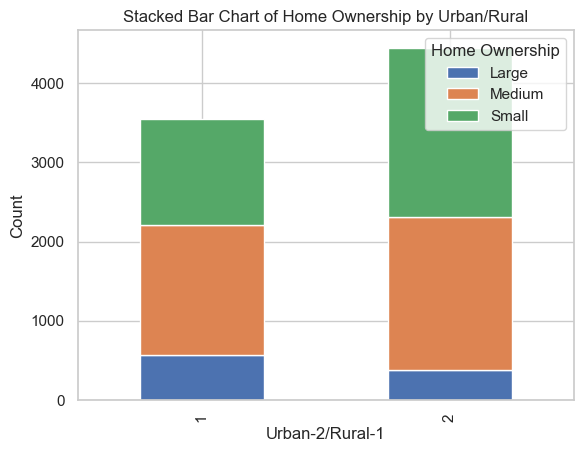

In [218]:
gra = ct.T.plot(kind='bar', stacked=True)
gra.set_xlabel("Urban-2/Rural-1")
gra.set_ylabel("Count")
gra.set_title("Stacked Bar Chart of Home Ownership by Urban/Rural")

gra.legend(title="Home Ownership")

plt.show()

## Modeling & Model Performances

Data Preprocessing Steps; 
 * Remove ID and Geo Columns 
 * Handle missing values etc.
 * Handle categoric variables etc.
 * Handle numeric variables etc.
 * Split Train/Test (70/30)
 
Model Selection
 * Since it's a classification problem you can use several classification algorithms such as  Random Forest, and Gradient Boosting etc. And compare their performances.
 
Model Training and Evaluation
 * Train each model on the training set. Evaluate their performance using metrics like accuracy, precision, recall, and F1-score. Create a confusion matrix for each model.



Please remember, it's important for us to add your comments about each model performances.

### 1) Modeling

In [237]:
# Change target column definitian for a binary classification problems

# 1=Rural ,  Urban=2

model_data['urbrur'] = model_data['urbrur'].replace({2:0 , 1:1})

In [238]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [239]:
data = model_data

# Removing the ID and geo columns 
# Since quint_rur and quint_urb columns are too correlated with our target we did also remove these features
data.drop(['hid','geo1','geo2', 'quint_rur','quint_urb'], axis=1, inplace=True) 


# If we had not removed these two features(quint_rur, quint_urb), what would have encountered in the model results? 


# Identifying categorical and numerical columns


# Handling missing values for numerical columns


# Encoding categorical variables

 
# Handling numerical variables


# Splitting the dataset into features (X) and target variable (y)
X = data.drop('urbrur', axis=1)
y = data['urbrur']

X = pd.get_dummies(X, dummy_na=True)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Training the Model1 Classifier


In [ ]:
# Training the Model2 Classifier


In [254]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.87

Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.84      0.85      1065
           2       0.88      0.88      0.88      1335

    accuracy                           0.87      2400
   macro avg       0.86      0.86      0.86      2400
weighted avg       0.87      0.87      0.87      2400



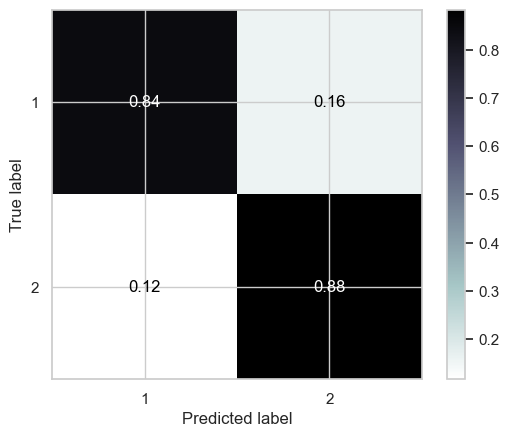

In [255]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='bone_r')

In [256]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

rf_classifier.score(X_test,y_test),confusion_matrix(y_test,y_pred)

(0.8654166666666666,
 array([[ 898,  167],
        [ 156, 1179]]))

In [257]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
gb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

           1       0.87      0.86      0.86      1065
           2       0.89      0.90      0.89      1335

    accuracy                           0.88      2400
   macro avg       0.88      0.88      0.88      2400
weighted avg       0.88      0.88      0.88      2400



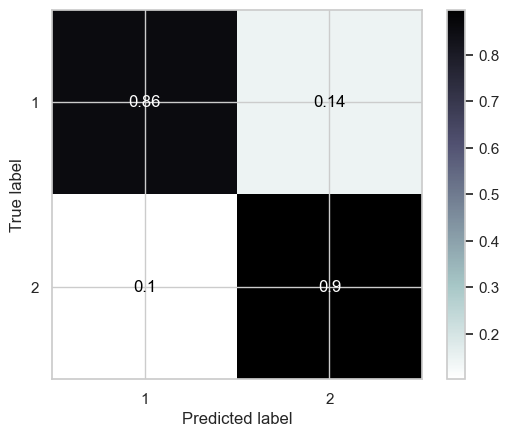

In [258]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='bone_r')

In [259]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

gb_classifier.score(X_test,y_test),confusion_matrix(y_test,y_pred)

(0.8791666666666667,
 array([[ 912,  153],
        [ 137, 1198]]))

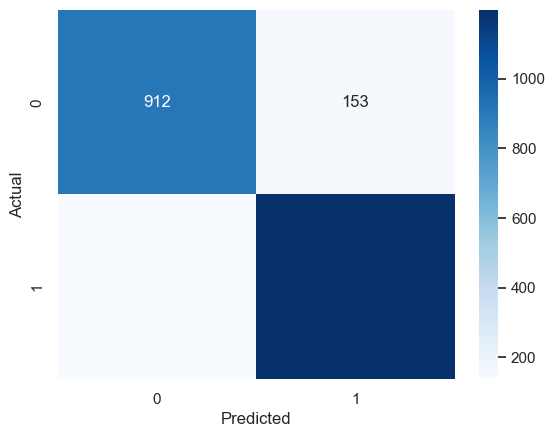

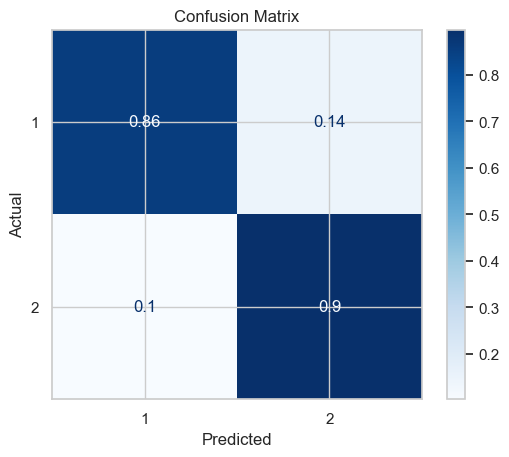

In [260]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

cm2=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 2) Model Performances

 ### 2.1) Model 1

In [ ]:
# Model Evaluation


# Plotting the confusion matrix



In [ ]:
df_features = pd.DataFrame(model1.feature_importances_, columns = ['Importance'],
             index = X_train.columns).sort_values('Importance', ascending = False).reset_index()
df_features.rename(columns = {'index':'Variable'}, inplace = True)
df_features

 ### 2.2) Model 2

In [ ]:
# Model Evaluation


# Plotting the confusion matrix



In [ ]:
df_features = pd.DataFrame(model2.feature_importances_, columns = ['Importance'],
             index = X_train.columns).sort_values('Importance', ascending = False).reset_index()
df_features.rename(columns = {'index':'Variable'}, inplace = True)
df_features

## Save Model

In [ ]:
model_file = 'finalized_model.pickle'
pickle.dump(model, open(model_file, 'wb')) # model is your final model object.

variable_file = 'model_variables.pickle'
pickle.dump(df_features, open(variable_file, 'wb')) # df_features is dataframe that holds final model variables.

In [ ]:
# Write your test predictions to Mongo DB

